<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

# حل معادله گرما یک‌بعدی با شبکه‌های عصبی آگاه از فیزیک (PINN) در PyTorch

این نوت‌بوک به بررسی جامع نحوه استفاده از شبکه‌های عصبی آگاه از فیزیک (PINN) برای حل معادله دیفرانسیل جزئی گرما در یک بعد می‌پردازد. ابتدا، معادله گرما و مفاهیم کلیدی PINN تشریح شده و سپس نحوه پیاده‌سازی آن با استفاده از کتابخانه PyTorch به تفصیل توضیح داده خواهد شد.

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

## ۱. معادله گرما یک‌بعدی

معادله گرما یک معادله دیفرانسیل جزئی (PDE) سهموی است که توزیع دما را در یک ناحیه مشخص در طول زمان توصیف می‌کند. فرم عمومی معادله گرما یک‌بعدی به صورت زیر است:
<html dir="rtl" lang="ar">

$$ \frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2} + \frac{Q(x,t)}{c\rho} $$
<html dir="rtl" lang="ar">

که در آن:
* `u(x,t)`: دما در موقعیت `x` و زمان `t` است.
* `k`: ضریب نفوذ گرمایی ماده است ( $k = \frac{K_0}{c\rho}$ ).
    * `K₀`: رسانندگی گرمایی ماده.
    * `c`: گرمای ویژه ماده.
    * `ρ`: چگالی (جرم مخصوص) ماده.
* `∂u/∂t`: نرخ تغییرات دما نسبت به زمان.
* `∂²u/∂x²`: لاپلاسین دما (نشان‌دهنده نحوه پخش دما در فضا).
* `Q(x,t)`: منبع یا چاه حرارتی داخلی در واحد حجم و در واحد زمان.
<html dir="rtl" lang="ar">

**معنای فیزیکی:** این معادله بیان می‌کند که تغییرات دما در یک نقطه با زمان، متناسب با نرخ پخش گرما در آن نقطه و هرگونه تولید یا جذب گرمای داخلی است.

در بسیاری از کاربردها، معادله بدون منبع حرارتی داخلی (`Q(x,t) = 0`) در نظر گرفته می‌شود که به فرم ساده‌تر زیر درمی‌آید:

$$ \frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2} $$

### شرایط اولیه و مرزی:
برای به دست آوردن یک جواب یکتا برای معادله گرما، نیاز به شرایط اولیه و مرزی داریم:

* **شرط اولیه (Initial Condition - IC):** توزیع دمای اولیه در سراسر دامنه در زمان `t=0` را مشخص می‌کند.
    $$ u(x, 0) = f(x) $$
    که `f(x)` یک تابع شناخته شده است.

* **شرایط مرزی (Boundary Conditions - BCs):** رفتار دما یا شار گرما را در مرزهای دامنه فضایی (مثلاً در `x=0` و `x=L` برای یک میله به طول `L`) مشخص می‌کند. انواع رایج شرایط مرزی عبارتند از:
    * **شرایط مرزی دیریکله (Dirichlet):** مقدار دما در مرزها ثابت یا تابعی از زمان است.
        $$ u(0, t) = g_1(t) $$
        $$ u(L, t) = g_2(t) $$
    * **شرایط مرزی نیومن (Neumann):** شار گرما در مرزها مشخص است. اگر مرزها عایق باشند، شار گرما صفر است ( `∂u/∂x = 0` ).
        $$ -K_0 \frac{\partial u}{\partial x}(0, t) = \phi_1(t) $$
        $$ -K_0 \frac{\partial u}{\partial x}(L, t) = \phi_2(t) $$
    * **شرایط مرزی رابین (Robin):** ترکیبی خطی از مقدار دما و شار گرما در مرزها مشخص است (معمولاً برای مدل‌سازی انتقال حرارت جابجایی در مرزها).
    * **شرایط مرزی تناوبی (Periodic):** دما و مشتقات آن در دو انتهای دامنه با هم برابرند.

### کاربردها:
معادله گرما در زمینه‌های مختلفی کاربرد دارد، از جمله:
* مهندسی مکانیک و شیمی: تحلیل انتقال حرارت در جامدات، سیالات و فرآیندهای صنعتی.
* فیزیک: مطالعه پدیده‌های نفوذ و پخش.
* علوم مواد: بررسی رفتار حرارتی مواد.
* ریاضیات مالی: مدل‌سازی قیمت اختیار معامله (معادله بلک-شولز شباهت زیادی به معادله گرما دارد).
* علوم زیستی: مدل‌سازی توزیع دما در بافت‌های زنده.

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

## ۲. شبکه‌های عصبی آگاه از فیزیک (PINN)

شبکه‌های عصبی آگاه از فیزیک (Physics-Informed Neural Networks - PINNs) نوعی شبکه عصبی هستند که قوانین فیزیکی حاکم بر یک سیستم (که معمولاً به صورت معادلات دیفرانسیل بیان می‌شوند) را مستقیماً در فرآیند یادگیری خود وارد می‌کنند. این کار با گنجاندن باقی‌مانده معادله دیفرانسیل و شرایط مرزی/اولیه در تابع هزینه شبکه عصبی انجام می‌شود.

### (الف) تعریف، مفهوم اصلی و معماری PINN:

* **تعریف:** PINN ها شبکه‌های عصبی‌ای هستند که برای تقریب زدن پاسخ معادلات دیفرانسیل آموزش داده می‌شوند. وجه تمایز اصلی آن‌ها، آگاهی از قوانین فیزیکی است.
* **مفهوم اصلی:** به جای اینکه شبکه صرفاً بر روی داده‌های مشاهده‌شده آموزش ببیند (مانند شبکه‌های عصبی سنتی)، PINN ها تلاش می‌کنند تا پاسخی را یاد بگیرند که نه تنها با داده‌های موجود (در صورت وجود) مطابقت داشته باشد، بلکه معادلات دیفرانسیل حاکم و شرایط مرزی/اولیه را نیز ارضا کند.
* **معماری:** معماری پایه یک PINN معمولاً یک شبکه عصبی پیشخور چندلایه (Multi-Layer Perceptron - MLP) است. ورودی‌های شبکه متغیرهای مستقل معادله (مثلاً `x` و `t` برای معادله گرما یک‌بعدی) هستند و خروجی شبکه، تقریب پاسخ معادله (مثلاً `u(x,t)`) است. تعداد لایه‌ها، تعداد نورون‌ها در هر لایه و توابع فعال‌سازی (مانند `tanh` یا `sigmoid`) از هایپرپارامترهای معماری هستند.
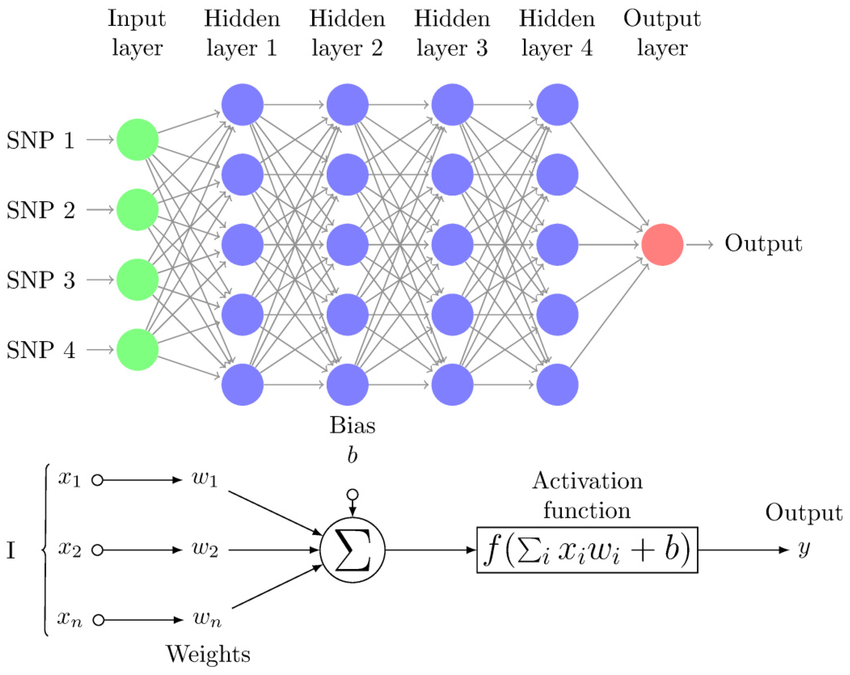

### (ب) نحوه گنجاندن قوانین فیزیکی (معادله دیفرانسیل) در تابع هزینه:

فرض کنید می‌خواهیم معادله دیفرانسیل عمومی زیر را حل کنیم:
$$ \mathcal{N}[u(x,t)] = 0, \quad (x,t) \in \Omega $$
که `Ω` دامنه مسئله و `N` یک عملگر دیفرانسیلی است.

شبکه عصبی `u_NN(x,t; θ)` پاسخی را با پارامترهای `θ` تقریب می‌زند. باقی‌مانده (residual) معادله دیفرانسیل به صورت زیر تعریف می‌شود:
$$ f(x,t; \theta) = \mathcal{N}[u_{NN}(x,t; \theta)] $$
هدف این است که این باقی‌مانده در تمام نقاط دامنه تا حد امکان به صفر نزدیک شود. بنابراین، یک بخش از تابع هزینه به میانگین مربعات این باقی‌مانده در مجموعه‌ای از نقاط نمونه‌برداری شده از دامنه (collocation points) اختصاص می‌یابد:
$$ MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} |f(x_f^i, t_f^i; \theta)|^2 $$
مشتقات مورد نیاز برای محاسبه `f` (مانند `∂u_NN/∂t` و `∂²u_NN/∂x²`) با استفاده از تکنیک مشتق‌گیری خودکار (Automatic Differentiation) که در کتابخانه‌های یادگیری عمیق مانند PyTorch موجود است، محاسبه می‌شوند.

### (ج) چگونگی اعمال شرایط مرزی و اولیه در ساختار PINN:

شرایط اولیه و مرزی نیز به طور مشابه در تابع هزینه گنجانده می‌شوند.
* **شرط اولیه:** اگر شرط اولیه `u(x,0) = h(x)` باشد، خطای مربوط به آن به صورت زیر محاسبه می‌شود:
    $$ MSE_{IC} = \frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}} |u_{NN}(x_{IC}^i, 0; \theta) - h(x_{IC}^i)|^2 $$
    که `(x_IC^i, 0)` نقاط نمونه‌برداری شده از شرط اولیه هستند.

* **شرایط مرزی:** اگر یک شرط مرزی دیریکله `u(x_b, t) = g_b(t)` در مرز `x_b` داشته باشیم، خطای آن به صورت زیر است:
    $$ MSE_{BC} = \frac{1}{N_{BC}} \sum_{i=1}^{N_{BC}} |u_{NN}(x_b, t_{BC}^i; \theta) - g_b(t_{BC}^i)|^2 $$
    که `(x_b, t_BC^i)` نقاط نمونه‌برداری شده از آن مرز هستند. برای شرایط مرزی نیومن که شامل مشتقات هستند، آن مشتقات نیز با مشتق‌گیری خودکار از خروجی شبکه محاسبه و در تابع هزینه لحاظ می‌شوند.

#### تابع هزینه کلی:
تابع هزینه کلی PINN ترکیبی وزن‌دار از این خطاها است:
$$ L(\theta) = w_f MSE_f + w_{IC} MSE_{IC} + w_{BC} MSE_{BC} $$
که `w_f`، `w_IC` و `w_BC` وزن‌هایی هستند که اهمیت نسبی هر بخش از خطا را تعیین می‌کنند. شبکه عصبی با بهینه‌سازی پارامترهای `θ` برای کمینه کردن این تابع هزینه آموزش داده می‌شود.



### (د) مزایا، معایب و محدودیت‌های استفاده از PINN:

* **مزایا:**
    * **عدم نیاز به داده‌های برچسب‌دار فراوان:** PINN ها می‌توانند حتی با داده‌های مشاهده‌ای کم یا بدون آن‌ها (در حالت purely physics-informed) آموزش ببینند، زیرا قوانین فیزیکی خود به عنوان نوعی داده عمل می‌کنند.
    * **حل مسائل در دامنه‌های نامنظم و ابعاد بالا:** برخلاف روش‌های سنتی مبتنی بر مش (mesh-based) که در دامنه‌های پیچیده یا ابعاد بالا با چالش مواجه می‌شوند، PINN ها به دلیل ماهیت بدون مش (mesh-free) خود انعطاف‌پذیری بیشتری دارند.
    * **حل مسائل معکوس (Inverse Problems):** PINN ها می‌توانند برای تخمین پارامترهای مجهول در معادلات دیفرانسیل (مانند ضریب نفوذ گرمایی `k`) با داشتن داده‌های مشاهده‌ای از پاسخ سیستم، استفاده شوند.
    * **ادغام طبیعی با یادگیری عمیق:** از تمام پیشرفت‌ها و ابزارهای موجود در حوزه یادگیری عمیق بهره می‌برند.
    * **تقریب پاسخ به صورت یک تابع پیوسته:** خروجی شبکه یک تابع پیوسته است که می‌تواند در هر نقطه از دامنه ارزیابی شود.

* **معایب و محدودیت‌ها:**
    * **چالش‌های آموزش:** فرآیند آموزش PINN ها می‌تواند دشوار باشد. انتخاب معماری مناسب، تابع فعال‌سازی، بهینه‌ساز، نرخ یادگیری و وزن‌های تابع هزینه می‌تواند چالش‌برانگیز باشد و به شدت بر عملکرد تأثیر بگذارد.
    * **دقت در محاسبه مشتقات بالا:** برای معادلات با مشتقات مرتبه بالا، دقت مشتق‌گیری خودکار و پایداری آموزش ممکن است کاهش یابد.
    * **رفتار با فرکانس‌های بالا و مقیاس‌های چندگانه:** یادگیری مولفه‌های با فرکانس بالا یا پدیده‌هایی با چندین مقیاس فضایی/زمانی می‌تواند برای PINN های استاندارد دشوار باشد.
    * **هزینه محاسباتی:** آموزش PINN ها، به ویژه برای مسائل پیچیده، می‌تواند از نظر محاسباتی سنگین باشد.
    * **مبانی نظری محدود:** در حالی که به سرعت در حال پیشرفت است، مبانی نظری مربوط به همگرایی و دقت PINN ها هنوز به طور کامل توسعه نیافته است.
    * **حساسیت به هایپرپارامترها:** عملکرد نهایی به شدت به انتخاب هایپرپارامترها وابسته است.

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

## ۳. حل معادله گرما یک‌بعدی با PINN (مثال مشخص)

در این بخش، روش حل معادله گرما یک‌بعدی ساده شده را با استفاده از PINN تشریح می‌کنیم.

**معادله مورد نظر:**
$$ \frac{\partial u}{\partial t} = k \frac{\partial^2 u}{\partial x^2} $$

**دامنه:**
* مکان: `x ∈ [0, L]` (برای مثال `L=1`)
* زمان: `t ∈ [0, T]` (برای مثال `T=1`)

**ضریب نفوذ گرمایی:**
* `k` (برای مثال `k=0.1`)

**شرط اولیه نمونه:**
$$ u(x, 0) = \sin(\frac{\pi x}{L}) $$

**شرایط مرزی نمونه (دیریکله همگن):**
$$ u(0, t) = 0 $$
$$ u(L, t) = 0 $$

**پاسخ تحلیلی (برای مقایسه):**
برای این مسئله خاص، پاسخ تحلیلی به صورت زیر است:
$$ u(x,t) = e^{-k (\frac{\pi}{L})^2 t} \sin(\frac{\pi x}{L}) $$

### (الف) تعریف شبکه عصبی برای تقریب پاسخ:
یک شبکه عصبی پیشخور (MLP)، `u_NN(x, t; θ)`، تعریف می‌شود که `x` و `t` را به عنوان ورودی گرفته و `u` را به عنوان خروجی برمی‌گرداند. این شبکه شامل چندین لایه پنهان با توابع فعال‌سازی (مثلاً `tanh`) است.

### (ب) فرموله‌بندی تابع هزینه کلی:

1.  **باقی‌مانده PDE (خطای فیزیک):**
    ابتدا مشتقات `∂u_NN/∂t` و `∂²u_NN/∂x²` با استفاده از مشتق‌گیری خودکار محاسبه می‌شوند.
    سپس باقی‌مانده PDE به صورت زیر تعریف می‌شود:
    $$ f(x,t; \theta) = \frac{\partial u_{NN}}{\partial t} - k \frac{\partial^2 u_{NN}}{\partial x^2} $$
    خطای مربوط به فیزیک مسئله در مجموعه‌ای از نقاط نمونه `(x_f^i, t_f^i)` از داخل دامنه `(0,L) × (0,T)` محاسبه می‌شود:
    $$ MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} |f(x_f^i, t_f^i; \theta)|^2 $$

2.  **خطای شرط اولیه (IC):**
    در نقاط نمونه `x_{IC}^i` از دامنه فضایی `[0,L]` در زمان `t=0`:
    $$ MSE_{IC} = \frac{1}{N_{IC}} \sum_{i=1}^{N_{IC}} |u_{NN}(x_{IC}^i, 0; \theta) - \sin(\frac{\pi x_{IC}^i}{L})|^2 $$

3.  **خطای شرایط مرزی (BC):**
    در نقاط نمونه `t_{BC}^i` از دامنه زمانی `[0,T]` در مرزهای `x=0` و `x=L`:
    $$ MSE_{BC_0} = \frac{1}{N_{BC0}} \sum_{i=1}^{N_{BC0}} |u_{NN}(0, t_{BC0}^i; \theta) - 0|^2 $$
    $$ MSE_{BC_L} = \frac{1}{N_{BCL}} \sum_{i=1}^{N_{BCL}} |u_{NN}(L, t_{BCL}^i; \theta) - 0|^2 $$
    خطای کلی شرایط مرزی: `MSE_BC = MSE_{BC_0} + MSE_{BC_L}`

4.  **تابع هزینه نهایی:**
    $$ L(\theta) = w_f MSE_f + w_{IC} MSE_{IC} + w_{BC} MSE_{BC} $$
    معمولاً وزن‌ها (`w_f`, `w_IC`, `w_BC`) برابر با ۱ در نظر گرفته می‌شوند یا برای تنظیم اهمیت هر بخش، مقادیر دیگری به آن‌ها اختصاص داده می‌شود.

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

## ۴. پیاده‌سازی با PyTorch و توضیحات کد

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۱. تعریف پارامترهای مسئله

In [2]:
# Physical parameters and domain
k_param = 0.1  # Thermal diffusivity
L_param = 1.0  # Length of the rod
T_param = 1.0  # Total time

# Initial condition: u(x,0) = sin(pi*x/L)
def initial_condition(x):
    return torch.sin(torch.pi * x / L_param)

# Boundary conditions: u(0,t) = 0, u(L,t) = 0
def boundary_condition_0(t):
    return torch.zeros_like(t)

def boundary_condition_L(t):
    return torch.zeros_like(t)

# Analytical solution for comparison
def analytical_solution(x, t, k, L):
    return torch.exp(-k * (torch.pi / L)**2 * t) * torch.sin(torch.pi * x / L)


<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۲. تعریف مدل شبکه عصبی (PINN)

شبکه عصبی ما یک MLP ساده با چند لایه پنهان و تابع فعال‌سازی Tanh خواهد بود. ورودی شبکه `(x, t)` و خروجی آن `u(x,t)` است.

In [3]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x, t):
        # Combine inputs
        inputs = torch.cat([x, t], dim=1)
        for i, layer in enumerate(self.layers):
            inputs = layer(inputs)
            if i < len(self.layers) - 1:  # No activation function on the output layer
                inputs = self.activation(inputs)
        return inputs

# Network architecture: [input, layer1, layer2, ..., output]
# Inputs include x and t (2 neurons)
# Output is u (1 neuron)
layers = [2, 50, 50, 50, 50, 1]
pinn_model = PINN(layers).to(device)
print(pinn_model)


PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (activation): Tanh()
)


<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۳. محاسبه مشتقات و باقی‌مانده PDE

برای محاسبه مشتقات `∂u/∂t` و `∂²u/∂x²` از `torch.autograd.grad` استفاده می‌کنیم.

In [ ]:
def pde_residual(model, x, t, k):
    u = model(x, t)

    # u_t
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # u_x
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # u_xx
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    residual = u_t - k * u_xx
    return residual

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۴. آماده‌سازی داده‌های آموزش

ما نیاز به سه دسته نقاط داریم:
1.  **نقاط شرط اولیه (IC):** در `t=0` برای `x` های مختلف در دامنه `[0,L]`.
2.  **نقاط شرایط مرزی (BC):** در `x=0` و `x=L` برای `t` های مختلف در دامنه `[0,T]`.
3.  **نقاط نمونه‌برداری (Collocation Points):** نقاط تصادفی `(x,t)` در داخل دامنه `(0,L) × (0,T)` برای ارزیابی باقی‌مانده PDE.

In [ ]:
# تعداد نقاط
N_ic = 100     # نقاط شرط اولیه
N_bc = 100     # نقاط شرایط مرزی ( برای هر مرز)
N_f = 10000    # نقاط نمونه‌برداری برای PDE

# 1. نقاط شرط اولیه (t=0)
x_ic = torch.rand((N_ic, 1), device=device) * L_param # x در [0, L]
t_ic = torch.zeros((N_ic, 1), device=device)
u_ic_actual = initial_condition(x_ic)
x_ic.requires_grad_(True)
t_ic.requires_grad_(True)

# 2. نقاط شرایط مرزی
# مرز x=0
x_bc0 = torch.zeros((N_bc, 1), device=device)
t_bc0 = torch.rand((N_bc, 1), device=device) * T_param # t در [0, T]
u_bc0_actual = boundary_condition_0(t_bc0)
x_bc0.requires_grad_(True)
t_bc0.requires_grad_(True)

# مرز x=L
x_bcL = torch.ones((N_bc, 1), device=device) * L_param
t_bcL = torch.rand((N_bc, 1), device=device) * T_param # t در [0, T]
u_bcL_actual = boundary_condition_L(t_bcL)
x_bcL.requires_grad_(True)
t_bcL.requires_grad_(True)

# 3. نقاط نمونه‌برداری برای PDE (داخل دامنه)
x_f = torch.rand((N_f, 1), device=device) * L_param # x در (0, L)
t_f = torch.rand((N_f, 1), device=device) * T_param # t در (0, T)
x_f.requires_grad_(True)
t_f.requires_grad_(True)

tensor([[0.3264],
        [0.9967],
        [0.0706],
        ...,
        [0.2255],
        [0.9051],
        [0.7366]], device='cuda:0', requires_grad=True)

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۵. حلقه آموزش

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1000/10000], Loss: 7.7530e-05, Loss_f: 6.0757e-05, Loss_ic: 2.0254e-06, Loss_bc: 1.4747e-05
Epoch [2000/10000], Loss: 5.8390e-05, Loss_f: 4.4476e-05, Loss_ic: 1.7682e-06, Loss_bc: 1.2146e-05
Epoch [3000/10000], Loss: 3.7528e-05, Loss_f: 3.1207e-05, Loss_ic: 1.3298e-06, Loss_bc: 4.9916e-06
Epoch [4000/10000], Loss: 2.7325e-05, Loss_f: 2.2091e-05, Loss_ic: 1.2932e-06, Loss_bc: 3.9410e-06
Epoch [5000/10000], Loss: 2.4460e-05, Loss_f: 1.6151e-05, Loss_ic: 3.0672e-06, Loss_bc: 5.2419e-06
Epoch [6000/10000], Loss: 1.1685e-05, Loss_f: 8.2317e-06, Loss_ic: 1.1088e-06, Loss_bc: 2.3449e-06
Epoch [7000/10000], Loss: 8.0137e-06, Loss_f: 5.1921e-06, Loss_ic: 9.5349e-07, Loss_bc: 1.8681e-06
Epoch [8000/10000], Loss: 6.1172e-06, Loss_f: 3.7608e-06, Loss_ic: 8.1288e-07, Loss_bc: 1.5435e-06
Epoch [9000/10000], Loss: 5.2937e-06, Loss_f: 3.2732e-06, Loss_ic: 8.6239e-07, Loss_bc: 1.1581e-06
Epoch [10000/10000], Loss: 4.0667e-06, Loss_f: 2.5917e-06, Loss_ic: 5.7269e-07, Loss_bc: 9.0227e-07


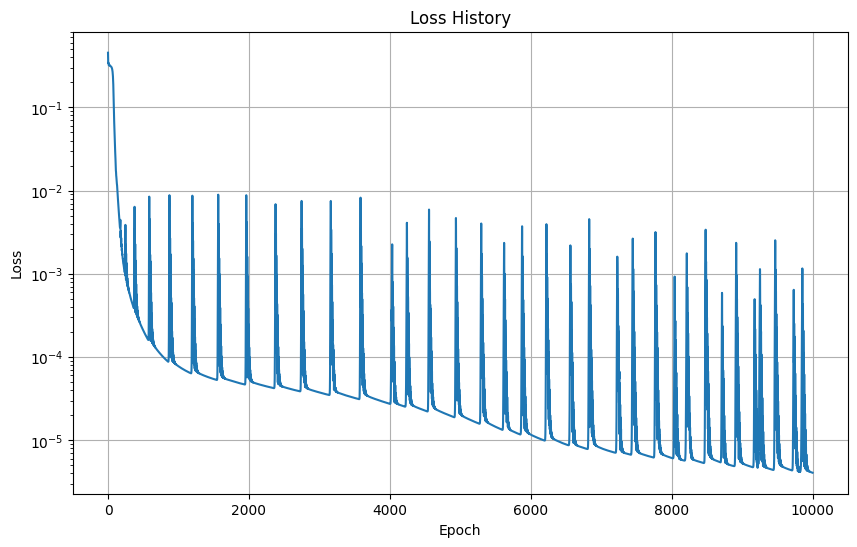

In [ ]:
optimizer = optim.Adam(pinn_model.parameters(), lr=1e-3)
loss_history = []
epochs = 10000

w_f = 1.0
w_ic = 1.0
w_bc = 1.0

for epoch in range(epochs):
    optimizer.zero_grad()

    # 1. خطای شرط اولیه
    u_pred_ic = pinn_model(x_ic, t_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic_actual)**2)

    # 2. خطای شرایط مرزی
    u_pred_bc0 = pinn_model(x_bc0, t_bc0)
    loss_bc0 = torch.mean((u_pred_bc0 - u_bc0_actual)**2)

    u_pred_bcL = pinn_model(x_bcL, t_bcL)
    loss_bcL = torch.mean((u_pred_bcL - u_bcL_actual)**2)
    loss_bc = loss_bc0 + loss_bcL

    # 3. خطای باقی‌مانده PDE
    residual_f = pde_residual(pinn_model, x_f, t_f, k_param)
    loss_f = torch.mean(residual_f**2)

    # تابع هزینه کلی
    total_loss = w_f * loss_f + w_ic * loss_ic + w_bc * loss_bc

    total_loss.backward()
    optimizer.step()
    loss_history.append(total_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4e}, Loss_f: {loss_f.item():.4e}, Loss_ic: {loss_ic.item():.4e}, Loss_bc: {loss_bc.item():.4e}')

# رسم نمودار تابع هزینه
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.show()

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

### ۴.۶. ارزیابی و نمایش نتایج

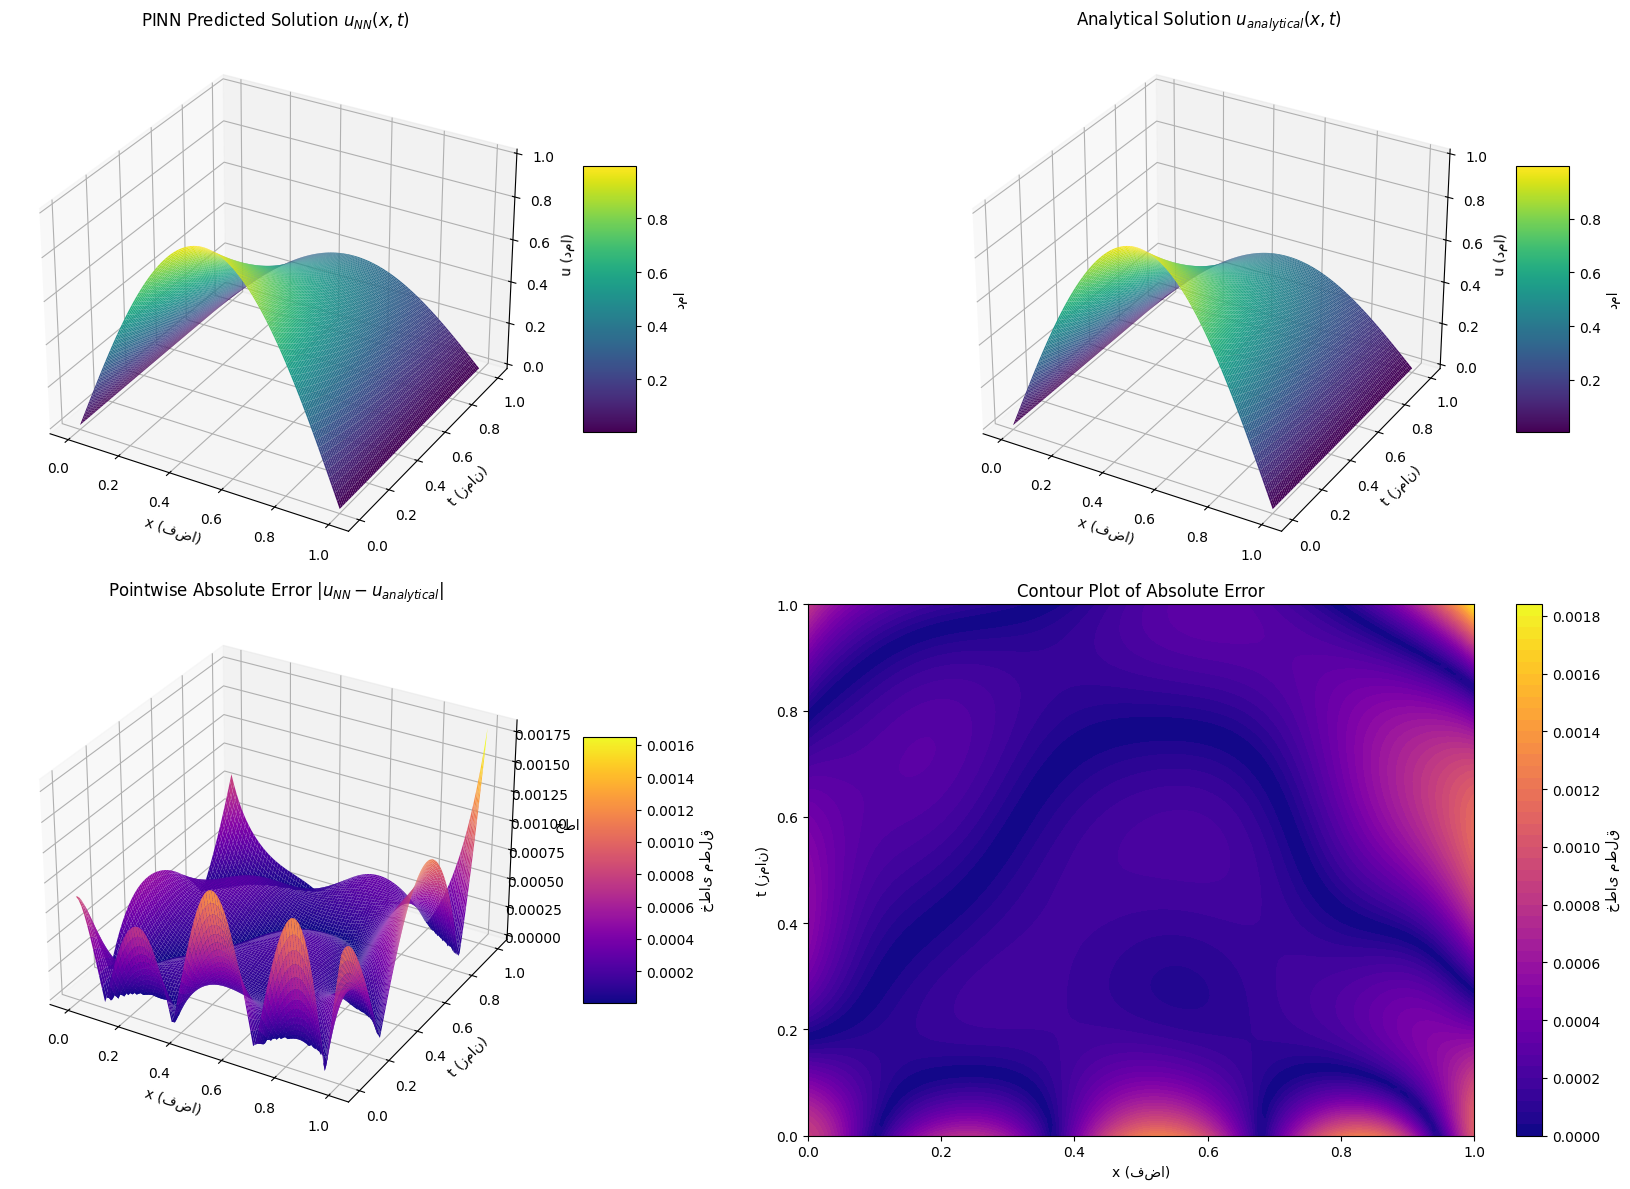

Relative L2 Error: 6.7945e-04


In [ ]:
# ایجاد یک گرید از نقاط برای ارزیابی و رسم
x_plot = torch.linspace(0, L_param, 100, device=device).view(-1, 1)
t_plot = torch.linspace(0, T_param, 100, device=device).view(-1, 1)
X_plot, T_plot = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing='ij')

x_eval = X_plot.reshape(-1, 1)
t_eval = T_plot.reshape(-1, 1)

pinn_model.eval()
with torch.no_grad():
    u_pred_plot = pinn_model(x_eval, t_eval).reshape(X_plot.shape)

u_analytical_plot = analytical_solution(X_plot, T_plot, k_param, L_param)

u_pred_np = u_pred_plot.cpu().numpy()
u_analytical_np = u_analytical_plot.cpu().numpy()
X_np = X_plot.cpu().numpy()
T_np = T_plot.cpu().numpy()

fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(221, projection='3d')
surf1 = ax1.plot_surface(X_np, T_np, u_pred_np, cmap='viridis', rstride=1, cstride=1, edgecolor='none')
ax1.set_title('PINN Predicted Solution $u_{NN}(x,t)$')
ax1.set_xlabel('x (فضا)')
ax1.set_ylabel('t (زمان)')
ax1.set_zlabel('u (دما)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5, label='دما')

ax2 = fig.add_subplot(222, projection='3d')
surf2 = ax2.plot_surface(X_np, T_np, u_analytical_np, cmap='viridis', rstride=1, cstride=1, edgecolor='none')
ax2.set_title('Analytical Solution $u_{analytical}(x,t)$')
ax2.set_xlabel('x (فضا)')
ax2.set_ylabel('t (زمان)')
ax2.set_zlabel('u (دما)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5, label='دما')

error_np = np.abs(u_pred_np - u_analytical_np)
ax3 = fig.add_subplot(223, projection='3d')
surf3 = ax3.plot_surface(X_np, T_np, error_np, cmap='plasma', rstride=1, cstride=1, edgecolor='none')
ax3.set_title('Pointwise Absolute Error $|u_{NN} - u_{analytical}|$')
ax3.set_xlabel('x (فضا)')
ax3.set_ylabel('t (زمان)')
ax3.set_zlabel('خطا')
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5, label='خطای مطلق')

ax4 = fig.add_subplot(224)
contour = ax4.contourf(X_np, T_np, error_np, cmap='plasma', levels=50)
ax4.set_title('Contour Plot of Absolute Error')
ax4.set_xlabel('x (فضا)')
ax4.set_ylabel('t (زمان)')
fig.colorbar(contour, ax=ax4, label='خطای مطلق')

plt.tight_layout()
plt.show()

l2_error = np.linalg.norm(u_pred_np - u_analytical_np) / np.linalg.norm(u_analytical_np)
print(f'Relative L2 Error: {l2_error:.4e}')

<div dir="rtl" style="text-align: right; font-family: Tahoma, sans-serif; line-height: 1.8;">

## جمع‌بندی

این نوت‌بوک نشان داد که چگونه می‌توان از شبکه‌های عصبی آگاه از فیزیک (PINN) برای حل معادله گرما یک‌بعدی استفاده کرد. با ترکیب داده‌های مربوط به شرایط اولیه، شرایط مرزی و باقی‌مانده معادله دیفرانسیل در تابع هزینه، شبکه عصبی آموزش داده می‌شود تا پاسخی را تولید کند که با قوانین فیزیکی مسئله سازگار باشد.

**نکات کلیدی:**
-   معماری شبکه، تابع فعال‌سازی، بهینه‌ساز و تعداد نقاط نمونه‌برداری هایپرپارامترهای مهمی هستند که بر عملکرد تأثیر می‌گذارند.
-   استفاده از بهینه‌سازهای مرتبه دوم مانند L-BFGS اغلب می‌تواند برای آموزش PINNها مفیدتر باشد، هرچند Adam نیز معمولاً نتایج خوبی ارائه می‌دهد. (در این مثال فقط Adam پیاده‌سازی شد.)
-   وزن‌دهی به بخش‌های مختلف تابع هزینه (`loss_f`, `loss_ic`, `loss_bc`) می‌تواند برای بهبود همگرایی و دقت مهم باشد.
-   PINNها یک ابزار قدرتمند برای حل معادلات دیفرانسیل، به ویژه در مواردی که پاسخ تحلیلی موجود نیست یا داده‌های آزمایشگاهی کمیاب هستند، محسوب می‌شوند.